# Analysis of biodiversity in US National Parks

The following project is an analysis of the biodiversity in several US national parks. It contains data about various species' conservation status and how often they were observed in each national park.

Our data is composed of two .csv files:  
**observations.csv** is a file with a record of various species and how often they were observed in each national park.  
**species_info.csv** contains info about said species, most notably its conservation status and scientific name.

Here are a few questions we answer in this analysis:

**1.** Are species on a state of threat less likely to be observed?  
**2.** Are some categories of species more likely to be endangered?  
**3.** Which category of species was observed the most?  
**4.** Which parks have the most observations?  
**5.** Do we see the same distribution of categories for all parks?

In [1]:
# Import relevant packages first.

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())


# i. Read and prepare data

The first step will be to read the csv files and remove any possible duplicates.
As we can see below, the _observations_ table has 3 columns: scientific name, park_name, and observations.  The *species_info* table has 4 columns: category, scientific name, common names, and conservation status.

Any possible duplicates in the observations table (same species and park) must be dealt with by adding up the number of observations (this could be because two different teams counted the species separately, for example.
As for the species_info table, we will ignore the common names and just join any possible duplicates with the same scientific name, as the common name isn't relevant for our analysis.

In [2]:
# Read the csv files
observations = pd.read_csv('observations.csv')
species_info = pd.read_csv('species_info.csv')

# Display the dataframes in order to analyze them
display(observations)
display(species_info)

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85
...,...,...,...
23291,Croton monanthogynus,Yosemite National Park,173
23292,Otospermophilus beecheyi,Bryce National Park,130
23293,Heterotheca sessiliflora ssp. echioides,Bryce National Park,140
23294,Dicranella rufescens,Yosemite National Park,171


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN
...,...,...,...,...
5819,Vascular Plant,Solanum parishii,Parish's Nightshade,NaN
5820,Vascular Plant,Solanum xanti,"Chaparral Nightshade, Purple Nightshade",NaN
5821,Vascular Plant,Parthenocissus vitacea,"Thicket Creeper, Virginia Creeper, Woodbine",NaN
5822,Vascular Plant,Vitis californica,"California Grape, California Wild Grape",NaN


In [3]:
# Print the datatypes, in order to check if they're correct
print(observations.dtypes,'\n')
print(species_info.dtypes)

scientific_name    object
park_name          object
observations        int64
dtype: object 

category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object


**conservation_status, in the species_info table, is an object variable, when it should be an (ordered) categorical variable.** 

**We should also now deal with any possible duplicates as well.**

In [4]:
# Deal with possible duplicates

# Remove any situation where the same species and the same park are listed more than once.
# Here, we sum the number of observations
observations = observations.groupby(['scientific_name', 'park_name'], as_index=False)['observations'].sum()

# Here we look for any duplicates (same scientific name) and drop them.
species_info['common_names'] = species_info.groupby(['scientific_name','conservation_status'], as_index = True)['common_names'].transform(lambda x: ','.join(x))
species_info = species_info.drop_duplicates(subset = 'scientific_name')

**Conservation status will be changed to an ordered categorical variable, as it corresponds to various degrees of severity. We can see that most species have a null conservation status, which we'll assume means non-threatened**.

In [5]:
#species_info.conservation_status = species_info.conservation_status.fillna('Not threatened')

# Change conservation_status to a categorical variable.

species_info.conservation_status = pd.Categorical(species_info.conservation_status,
                                    categories =  ['Endangered', 'Threatened', 'Species of Concern', 'In Recovery'],#, 'Not threatened'],
                                                    ordered = True)
display(species_info.dtypes)

category                 object
scientific_name          object
common_names             object
conservation_status    category
dtype: object

In [6]:
# Now that we have the datasets prepared, let's check the datatypes again
print('Observations: \n')
observations.info()
print('\n\nSpecies info:')
species_info.info()

Observations: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22164 entries, 0 to 22163
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  22164 non-null  object
 1   park_name        22164 non-null  object
 2   observations     22164 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 519.6+ KB


Species info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5541 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   category             5541 non-null   object  
 1   scientific_name      5541 non-null   object  
 2   common_names         178 non-null    object  
 3   conservation_status  178 non-null    category
dtypes: category(1), object(3)
memory usage: 178.8+ KB


# ii. Analyzing Data.

**Question 1. Are species on a state of threat less likely to be observed?**

In [7]:
# Check how many species are in each conservation status
print('Number of species per conservation status: \n')
print(species_info.conservation_status.value_counts(dropna = False))

Number of species per conservation status: 

NaN                   5363
Species of Concern     151
Endangered              15
Threatened               9
In Recovery              3
Name: conservation_status, dtype: int64


We can see that the overwhelming majority of species aren't threatened (if we assume that a null conservation status means that it's not threatened, which is a reasonable assumption).

Now let's take a look at the mean number of observations per category. We expect that species which aren't threatened to be observed more often than those which are. We will plot the mean number of observations per category, as well as the standard deviation of the number of observations, to see if that checks out.


,conservation_status,mean_observations,stdev_observations
1,Endangered,186.533333,141.541922
4,Threatened,280.666667,17.120488
3,Species of Concern,546.880795,147.209628
2,In Recovery,464.000000,5.354126
0,NaN,601.425322,134.741575


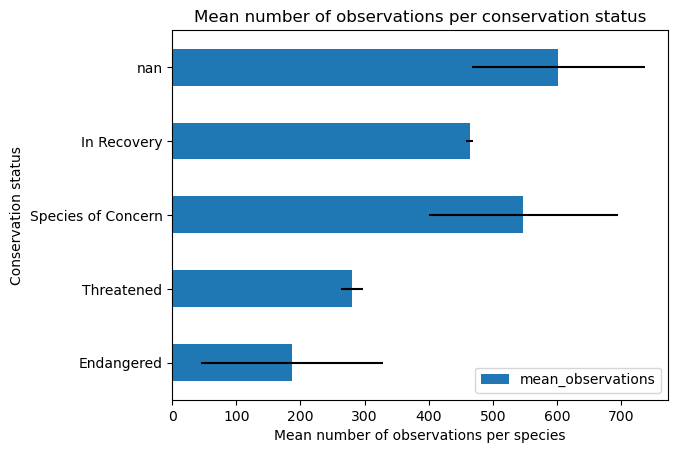

In [8]:
# We create a temporary table, obs_species, which joins the number of observations per species.
# The mean_observations_by_status DataFrame calculates the mean number of observations and standard deviation
mean_observations_by_status = pysqldf("""
WITH obs_species AS (
    SELECT observations.scientific_name,
           conservation_status,
           SUM(observations) AS total_observations
    FROM   observations
    JOIN   species_info
    ON     observations.scientific_name = species_info.scientific_name
    GROUP BY observations.scientific_name, conservation_status
)

SELECT
        conservation_status,
        AVG (total_observations) AS mean_observations,
        AVG(total_observations*total_observations) - AVG(total_observations)*AVG(total_observations) as var_observations
FROM    
        obs_species
GROUP BY
        conservation_status""")


# SQLite doesn't have a built-in standard deviation function, so we must calculate it like this.
mean_observations_by_status['stdev_observations'] = np.sqrt(mean_observations_by_status['var_observations'])
mean_observations_by_status = mean_observations_by_status.drop(columns = ['var_observations'])

# Ensure that conservation_status is categorical
mean_observations_by_status.conservation_status = pd.Categorical(mean_observations_by_status.conservation_status,
                                    categories =  ['Endangered', 'Threatened', 'Species of Concern', 'In Recovery'],#, 'Not threatened'],
                                                    ordered = True)

# Sort by conservation status
mean_observations_by_status = mean_observations_by_status.sort_values('conservation_status')

# Display the DataFrame
display (mean_observations_by_status.sort_values('conservation_status'))

# Plot the mean number of observations per conservation status, using the standard deviation as the error bar.
mean_observations_by_status.plot.barh(x = 'conservation_status', y = 'mean_observations', xerr = 'stdev_observations')
plt.xlabel('Mean number of observations per species')
plt.ylabel('Conservation status')
plt.title('Mean number of observations per conservation status')
plt.show ()

**As we would expect, endangered and threatened species are observed significantly less than non-threatened species.  It's also interesting to see that species of concern and have been sighted at similar numbers to non-threatened species.**

**Question 2. Which categories of species are more likely to be endangered?**

In [9]:
# First, we want to see the mean fraction of species in each conservation status.

mean_percentage_status = species_info.conservation_status.value_counts()/species_info.scientific_name.nunique()
mean_percentage_status = mean_percentage_status.sort_index()
display(mean_percentage_status)

mps = mean_percentage_status.to_numpy()


Endangered            0.002707
Threatened            0.001624
Species of Concern    0.027251
In Recovery           0.000541
Name: conservation_status, dtype: float64

In [10]:
# Count the number of species for each category.

category_count = pysqldf("""
SELECT
    category,
    COUNT(*) as number_of_species
FROM
    species_info
GROUP BY
    category
""")

display(category_count)

,category,number_of_species
0,Amphibian,79
1,Bird,488
2,Fish,125
3,Mammal,176
4,Nonvascular Plant,333
5,Reptile,78
6,Vascular Plant,4262


In [11]:
# Check which species are more likely to be in each conservation status.

status_percentage =  pysqldf("""
SELECT  
    s.category,
    s.conservation_status,
    COUNT(*) AS 'number_of_species',
    t.total_species AS 'category_total',
    CAST (COUNT(*) AS REAL) / t.total_species * 100 AS 'percentage'

FROM
    species_info s
JOIN (
    SELECT
        category,
        COUNT(*) AS total_species
    FROM
        species_info
    GROUP BY
        category
) t ON s.category = t.category
GROUP BY
    s.category,
    s.conservation_status, 
    t.total_species;
""").dropna()

display(status_percentage)

status_percentage_pivot = status_percentage.pivot(index = 'conservation_status',
                                                  columns = 'category',
                                                  values = 'percentage')

status_percentage_pivot = status_percentage_pivot.fillna(0).astype(float)
display(status_percentage_pivot)

,category,conservation_status,number_of_species,category_total,percentage
1,Amphibian,Endangered,1,79,1.265823
2,Amphibian,Species of Concern,4,79,5.063291
3,Amphibian,Threatened,2,79,2.531646
5,Bird,Endangered,4,488,0.819672
6,Bird,In Recovery,3,488,0.614754
7,Bird,Species of Concern,68,488,13.934426
9,Fish,Endangered,3,125,2.400000
10,Fish,Species of Concern,4,125,3.200000
11,Fish,Threatened,3,125,2.400000
13,Mammal,Endangered,6,176,3.409091


category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.265823,0.819672,2.4,3.409091,0.000000,0.000000,0.023463
In Recovery,0.000000,0.614754,0.0,0.000000,0.000000,0.000000,0.000000
Species of Concern,5.063291,13.934426,3.2,12.500000,1.501502,6.410256,1.008916
Threatened,2.531646,0.000000,2.4,1.136364,0.000000,0.000000,0.046926


,category,conservation_status,percentage
0,Amphibian,Endangered,1.265823
1,Bird,Endangered,0.819672
2,Fish,Endangered,2.400000
3,Mammal,Endangered,3.409091
4,Vascular Plant,Endangered,0.023463


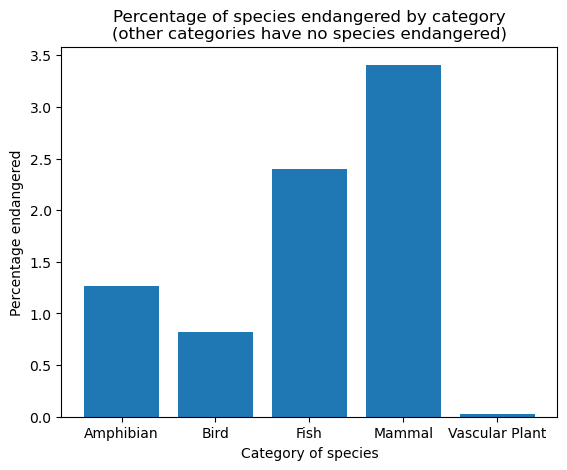

In [12]:
# With these numbers, we can now plot the percentage of species which are endangered for each category

endangered_percentage =  pysqldf("""
SELECT  
    s.category,
    s.conservation_status,
    CAST (COUNT(*) AS REAL) / t.total_species * 100 AS 'percentage'
FROM
    species_info s
JOIN (
    SELECT
        category,
        COUNT(*) AS total_species
    FROM
        species_info
    GROUP BY
        category
) t ON s.category = t.category
WHERE
    s.conservation_status = 'Endangered'
GROUP BY
    s.category,
    s.conservation_status, 
    t.total_species;
""").dropna()



# Display the table
display(endangered_percentage)

# Plot the chart
plt.bar   (endangered_percentage.category, endangered_percentage.percentage)
plt.xticks(endangered_percentage.category)
plt.xlabel('Category of species')
plt.ylabel('Percentage endangered')
plt.title ('Percentage of species endangered by category\n(other categories have no species endangered)')
plt.show  ()

We now know the percentage of endangered species for each category, and we can do the same thing for the conservation status.

**But are these values statistically different from the average?**  
In order to answer that, we use a binomial test to see if there's any significant difference from the mean.

In [13]:
from sklearn.impute import SimpleImputer 

def fill_with_column_mean(df):
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
    imputer = imputer.fit(df)
    return imputer.transform(df)



from scipy.stats import binom_test


# This table has the total amount of species per each category
status_percentage_category_total    = status_percentage.pivot(index   = 'conservation_status',
                                                              columns = 'category',
                                                              values  = 'category_total')

spct = fill_with_column_mean(status_percentage_category_total)

status_percentage_category_total = pd.DataFrame (spct,
                                                 columns = status_percentage_pivot.columns,
                                                 index = status_percentage_pivot.index).astype(int)

display (status_percentage_category_total)


# This table has the number of species in each category and each conservation status
status_percentage_number_of_species = status_percentage.pivot(index = 'conservation_status',
                                                           columns  = 'category',
                                                           values   = 'number_of_species'
                                                           ).fillna(0).astype(int)
spns = status_percentage_number_of_species.to_numpy()

display (status_percentage_number_of_species)


category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,79,488,125,176,333,78,4262
In Recovery,79,488,125,176,333,78,4262
Species of Concern,79,488,125,176,333,78,4262
Threatened,79,488,125,176,333,78,4262


category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1,4,3,6,0,0,1
In Recovery,0,3,0,0,0,0,0
Species of Concern,4,68,4,22,5,5,43
Threatened,2,0,3,2,0,0,2


In [14]:
# Binomial test for each result. We take the number of successes (# of species in a particular conservation status),
# number of attempts (total number of species per category),
# and the probability of the null hypothesis (probability that it's the same fraction of species as the average)

binom_test_table = np.zeros((spns.shape[0], spns.shape[1]))

for i in range (spns.shape[0]) :
    for j in range(spns.shape[1]):
        binom_test_table[i,j] = binom_test (spns[i,j], spct[i,j], mps[i])

binom_test_table = pd.DataFrame (binom_test_table,
                                 columns = status_percentage_pivot.columns,
                                 index = status_percentage_pivot.index).round(3)

display(binom_test_table)

/usr/lib/python3/dist-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,0.193,0.045,0.005,0.000,1.000,1.000,0.000
In Recovery,1.000,0.046,1.000,1.000,1.000,1.000,0.002
Species of Concern,0.169,0.000,0.587,0.000,0.235,0.062,0.000
Threatened,0.001,1.000,0.000,0.004,1.000,1.000,1.000


**With this test, using p < 0.05, we can conclude that birds, mammals and fish are more likely than average of being endagered, while vascular plants are less likely to be endangered. As for amphibians, nonvascular plants and reptiles, we can't make any conclusions.**

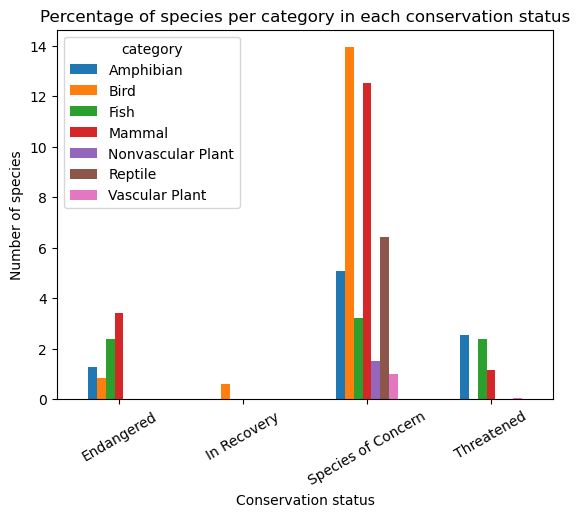

In [15]:
# We can also plot how many species are in each conservation status

status_percentage_pivot.plot.bar(rot = 30)
plt.xlabel('Conservation status')
plt.ylabel('Number of species')
plt.title ('Percentage of species per category in each conservation status')
plt.show  ()

In [16]:
# See how many species of each category are endangered

category_conservation =  pysqldf("""
SELECT  
        category,
        conservation_status,
        COUNT(*) AS 'number_of_species'
FROM
        species_info
GROUP BY
        category,
        conservation_status""").dropna()

category_conservation = category_conservation.pivot(index = 'conservation_status',
                                                    columns = 'category',
                                                    values = 'number_of_species')

category_conservation = category_conservation.fillna(0).astype(int)
category_conservation

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1,4,3,6,0,0,1
In Recovery,0,3,0,0,0,0,0
Species of Concern,4,68,4,22,5,5,43
Threatened,2,0,3,2,0,0,2


Text(0.5, 1.0, 'Number of species by category in each conservation status')

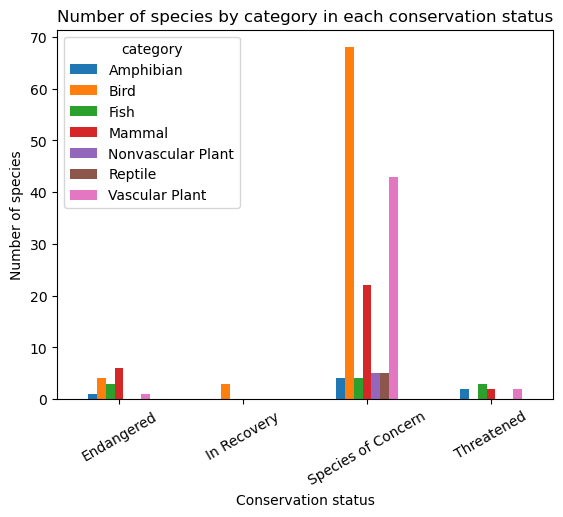

In [17]:
category_conservation.plot.bar(rot = 30)
plt.xlabel('Conservation status')
plt.ylabel('Number of species')
plt.title ('Number of species by category in each conservation status')

 **1.** Out of those we know endangerment status, mammals are the most affected group in the list.

In [18]:
# Which species were observed the most.

total_observations = pysqldf("""
SELECT  
        scientific_name,
        SUM(observations) AS 'total_observations'
FROM
        observations
GROUP BY
        scientific_name
ORDER BY
        total_observations DESC""")

total_observations

,scientific_name,total_observations
0,Streptopelia decaocto,1785
1,Holcus lanatus,1780
2,Castor canadensis,1725
3,Hypochaeris radicata,1720
4,Puma concolor,1711
...,...,...
5536,Rana sierrae,144
5537,Noturus baileyi,143
5538,Vermivora bachmanii,141
5539,Canis rufus,137


In [19]:
# Which categories were observed the most.

total_observations_category = pysqldf("""
SELECT  
        category,
        SUM(observations) AS 'total_observations'
FROM
        observations
LEFT JOIN
        species_info
ON
        species_info.scientific_name = observations.scientific_name
GROUP BY
        category
ORDER BY
        total_observations DESC""")

total_observations_category


,category,total_observations
0,Vascular Plant,2555090
1,Bird,292833
2,Nonvascular Plant,190653
3,Mammal,116696
4,Fish,70818
5,Reptile,44678
6,Amphibian,43971


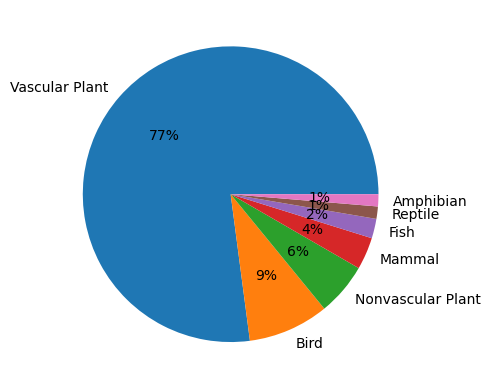

In [20]:
plt.pie(total_observations_category['total_observations'], labels = total_observations_category['category'], autopct='%1.0f%%')
plt.show()

Vascular birds are by far the most observed category.

**Question 4.** Which parks have the most observations?  

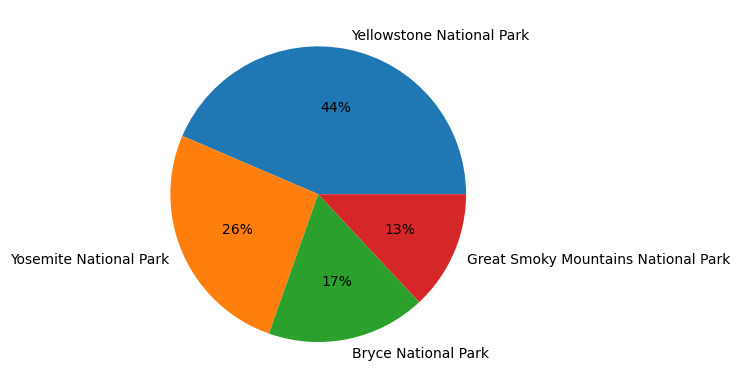

In [21]:
# See which parks had the most observations

park_observations = pysqldf("""
SELECT  
        park_name,
        SUM(observations) AS 'total_observations'
FROM
        observations
GROUP BY
        park_name
ORDER BY
        total_observations DESC""")

plt.pie  (park_observations.total_observations, labels = park_observations.park_name, autopct='%1.0f%%')
plt.show ()

Almost half of the observation in this database are in Yellowstone National Park.

**Question 5.** Do we see the same distribution of categories for all parks?

,category,total_observations
0,Vascular Plant,1112927
1,Bird,127251
2,Nonvascular Plant,83021
3,Mammal,50795
4,Fish,30574
5,Reptile,19554
6,Amphibian,19440


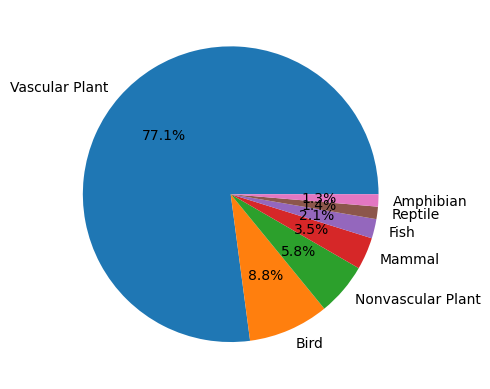

In [22]:
yellowstone = pysqldf("""
SELECT  
        category,
        SUM(observations) AS 'total_observations'
FROM
        observations
LEFT JOIN
        species_info
ON
        species_info.scientific_name = observations.scientific_name
WHERE
        park_name = 'Yellowstone National Park'
GROUP BY
        category
ORDER BY
        total_observations DESC""")

display(yellowstone)

plt.pie (yellowstone.total_observations, labels = yellowstone.category, autopct='%0.1f%%')
plt.show()

,category,total_observations
0,Vascular Plant,665461
1,Bird,76207
2,Nonvascular Plant,49783
3,Mammal,30339
4,Fish,18615
5,Reptile,11483
6,Amphibian,11444


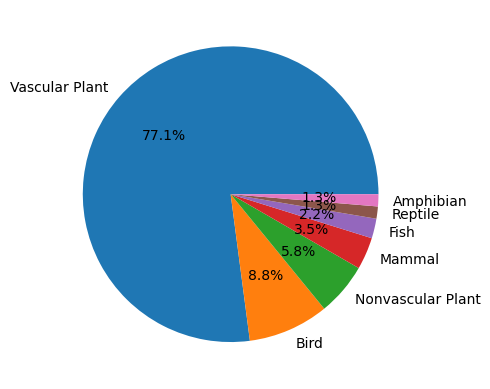

In [23]:
yosemite = pysqldf("""
SELECT  
        category,
        SUM(observations) AS 'total_observations'
FROM
        observations
LEFT JOIN
        species_info
ON
        species_info.scientific_name = observations.scientific_name
WHERE
        park_name = 'Yosemite National Park'
GROUP BY
        category
ORDER BY
        total_observations DESC""")

display(yosemite)

plt.pie (yosemite.total_observations, labels = yosemite.category, autopct='%0.1f%%')
plt.show()

,category,total_observations
0,Vascular Plant,443083
1,Bird,51647
2,Nonvascular Plant,32992
3,Mammal,20550
4,Fish,12423
5,Reptile,7950
6,Amphibian,7380


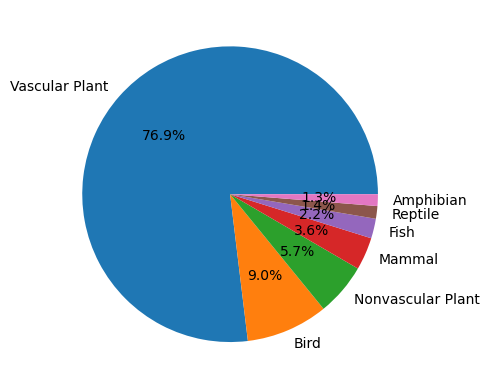

In [24]:
bryce = pysqldf("""
SELECT  
        category,
        SUM(observations) AS 'total_observations'
FROM
        observations
LEFT JOIN
        species_info
ON
        species_info.scientific_name = observations.scientific_name
WHERE
        park_name = 'Bryce National Park'
GROUP BY
        category
ORDER BY
        total_observations DESC""")

display(bryce)

plt.pie (bryce.total_observations, labels = bryce.category, autopct='%0.1f%%')
plt.show()

,category,total_observations
0,Vascular Plant,333619
1,Bird,37728
2,Nonvascular Plant,24857
3,Mammal,15012
4,Fish,9206
5,Amphibian,5707
6,Reptile,5691


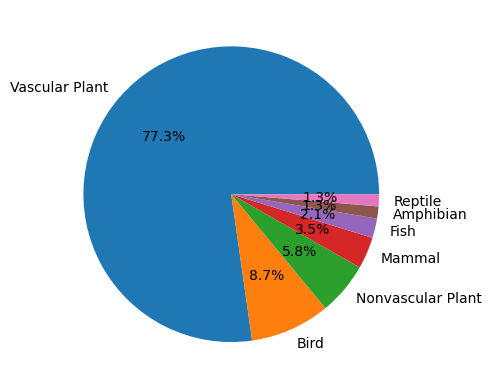

In [25]:
great_smoky = pysqldf("""
SELECT  
        category,
        SUM(observations) AS 'total_observations'
FROM
        observations
LEFT JOIN
        species_info
ON
        species_info.scientific_name = observations.scientific_name
WHERE
        park_name = 'Great Smoky Mountains National Park'
GROUP BY
        category
ORDER BY
        total_observations DESC""")

display(great_smoky)

plt.pie (great_smoky.total_observations, labels = great_smoky.category, autopct='%0.1f%%')
plt.show()

**Despite having very different numbers of observations, and being located in different locations, these national parks show almost the same percentage of observations for each category.**

# iii. Conclusions

**Having made this analysis, we can draw the following conclusions:  **
1. Endangered and threatened species are observed significantly less than non-threatened species, while species of concern and have been sighted at similar numbers to non-threatened species.  
2. Birds, mammals and fish are more likely than average of being endagered, while vascular plants are less likely to be endangered. As for amphibians, nonvascular plants and reptiles, we can't make any conclusions.  
3. Vascular birds are by far the most observed category, and the proportions of each category are almost identical to all parks.  
This isn't necessarily a consequence of the actual numbers, it could very well be a consequence of the type of observation being made. For example, a botanist won't likely be looking for fish. It could also be a reflection not of the actual numbers but of the way different species interact with us. Birds, the 2nd most observed category, can be more easily seen flying than we can see amphibians, which are seen almost exclusively in wet areas.